##  Copyright and GNU general public license
Copyright (C) 2021 Ayush Malik

This program is free software: you can redistribute it and/or modify
it under the terms of the GNU General Public License as published by
the Free Software Foundation, either version 3 of the License, or
(at your option) any later version.
 
This program is distributed in the hope that it will be useful,
but WITHOUT ANY WARRANTY; without even the implied warranty of
MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the GNU General Public License for more details.
You should have received a copy of the GNU General Public License
along with this program.  If not, see <http://www.gnu.org/licenses/>.

<b>Author:</b> Ayush Malik
<br><b>Email:</b> ayush.malik@ucalgary.ca <br>
<b> Acknowledgment: </b> This project was implemented as part of the course  ENEL-645, Data Mining & Machine Learning, Fall 2019. I would like to thank Prof: Henry Leung, TA King Ma and my friend Alhamd Khan for their guidance, help and support.  

## Description of the dataset

Li, K., Wan, G., Cheng, G., Meng, L., & Han, J. (2019). Object Detection in Optical Remote Sensing Images: A Survey and A New Benchmark. arXiv preprint arXiv:1909.00133. https://arxiv.org/ftp/arxiv/papers/1909/1909.00133.pdf
<br>
<ol> <li> 23463 images and 192472 instances, covering 20 object classes, with a 800x800 pixel per image.</li>
<li>Each of the 20 classes contains about 1200 images.</li>
<li> This project was limited to three object classes (airplane, ship, vehicles).</li>

## Mounting Google Drive and Importing Libraries

The project was originally implemented in pycharm in December, 2019 but to document it better on github it was impemented on Colab utilizing the GPU acceleration offered by Colab.<br> 
The Annotations file and the images are stored in the google drive. The following code cell mounts the drive to Google colab environment. After mounting the drive, the files stored in the drive can be accessed.

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
from __future__ import print_function
from PIL import Image
import numpy as np
from matplotlib import pyplot as plt
import glob
import pandas as pd
import xml.etree.ElementTree as ET
from keras.utils import to_categorical
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K
from matplotlib import pyplot as plt

## Function for reading annotations file

Function for Reading the Bounding Boxes. The bounding boxes and labels are parsed from the xml files and stored in a dataframe.

In [ ]:
batch_size = 64
epochs = 40
def xml_to_csv(path):
    
    classlist = ['ship','vehicle','airplane']
    xml_list = []
    for xml_file in glob.glob(path + '/*.xml'):
        tree = ET.parse(xml_file)
        root = tree.getroot()
        for member in root.findall('object'):
            
            if any (x in member.find('name').text for x in classlist):
            
                value = (root.find('filename').text,
                        int(root.find('size')[0].text),
                        int(root.find('size')[1].text),
                        member.find('name').text,
                        int(member.find('bndbox')[0].text),
                        int(member.find('bndbox')[1].text),
                        int(member.find('bndbox')[2].text),
                        int(member.find('bndbox')[3].text)
                        )
                xml_list.append(value)
    column_name = ['filename', 'width', 'height',
                'class', 'xmin', 'ymin', 'xmax', 'ymax']
    xml_df = pd.DataFrame(xml_list, columns=column_name)
    return xml_df

## Train-set: images and annotations file

In the following code cell, all the xml annotation files of the training dataset are read. From these files, information regarding the bounding boxes and labels of all the sub-image is extracted and stored in a dataframe. After this all the sub-images are cropped and stored in a seprate dataframe called subImagesTrainset. The sub-images have been cropped and resized to a fixed 32X32 dimension. This was done because all the sub-images are of variable dimensions and it is required to have a fixed length input matrix size to feed to the ML model.

In [ ]:
annotation_pathTrain = '/content/gdrive/MyDrive/train_annotatations'
xml_dataframeTrain = xml_to_csv(annotation_pathTrain)
xml_dataframeTrain.to_csv('full_dataset_labels1.csv')

dataframeTrain = pd.read_csv('full_dataset_labels1.csv')
dataframeTrain = dataframeTrain.to_numpy()
xml_dataframeTrain = xml_dataframeTrain.to_numpy()

inputDimension = 32  
images = []
train_images_path=glob.glob('/content/gdrive/MyDrive/train_images/*.jpg')

trainsetLength=dataframeTrain.shape[0]
trainLabels=[]

"""load,crop and store the resized sub-images"""

for i in range(0,trainsetLength):
    trainLabels.append(dataframeTrain[i][4])
   
    image = Image.open('/content/gdrive/MyDrive/train_images/'+dataframeTrain[i][1])
    cropped=image.crop((dataframeTrain[i][5],dataframeTrain[i][6],dataframeTrain[i][7],dataframeTrain[i][8]))
    cropped = cropped.resize((inputDimension, inputDimension))
    cropped=np.asarray( cropped ) / 255.0
    images.append( cropped )
    
subImagesTrainset = np.array(images)
imagenames = xml_dataframeTrain[0]
object_location = xml_dataframeTrain[4:8]
object_classes = xml_dataframeTrain[3]
print('image dataset size', np.array(images).shape)


One-Hot encoding the categorical labels and storing the final encoded labels as trainLabelsEncoded using a dictionary.

In [ ]:
dict = {'airplane':0,'vehicle':1,'ship':2}
train_labels = np.vectorize(dict.get)(trainLabels)
trainLabelsEncoded = to_categorical(train_labels)


## Splitting the data set into Test and train sets

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(subImagesTrainset, trainLabelsEncoded, test_size=0.2, random_state=42)

## CNN Model configuration and Training

A CNN model with two 2D convulutional layers, one maxpooling layer and three fully connected dense layers with flatten and dropout layers before the dense layers.

In [ ]:
input_shape = (inputDimension,inputDimension,3)
model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=input_shape))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.15))
model.add(Flatten())  #features as 1D
model.add(Dense(128, activation='relu'))
model.add(Dense(64, activation='relu'))
#model.add(Dropout(0.5))
model.add(Dense(3, activation='softmax'))

model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adadelta(),
              metrics=['accuracy'])
history = model.fit(X_train,y_train,
          batch_size=batch_size,
          epochs=300,
          verbose=1,validation_split=0.2)

Epoch 1/300
537/537 [==============================] - 11s 8ms/step - loss: 0.9783 - accuracy: 0.5453 - val_loss: 0.7812 - val_accuracy: 0.6390
Epoch 2/300
537/537 [==============================] - 3s 6ms/step - loss: 0.7752 - accuracy: 0.6309 - val_loss: 0.7515 - val_accuracy: 0.6390
Epoch 3/300
537/537 [==============================] - 3s 6ms/step - loss: 0.7416 - accuracy: 0.6391 - val_loss: 0.7326 - val_accuracy: 0.6390
Epoch 4/300
537/537 [==============================] - 4s 7ms/step - loss: 0.7270 - accuracy: 0.6366 - val_loss: 0.7145 - val_accuracy: 0.6396
Epoch 5/300
537/537 [==============================] - 3s 6ms/step - loss: 0.7077 - accuracy: 0.6376 - val_loss: 0.6951 - val_accuracy: 0.6480
Epoch 6/300
537/537 [==============================] - 3s 6ms/step - loss: 0.6856 - accuracy: 0.6509 - val_loss: 0.6734 - val_accuracy: 0.6769
Epoch 7/300
537/537 [==============================] - 3s 6ms/step - loss: 0.6620 - accuracy: 0.6862 - val_loss: 0.6522 - val_accuracy: 0.714

In [ ]:
model.save('/content/gdrive/MyDrive/')

INFO:tensorflow:Assets written to: /content/gdrive/MyDrive/assets


## Test-set: images and annotations file
In the following code cell, all the xml annotation files of the test set are read. From these files, information regarding the bounding boxes and labels of all the sub-image is extracted and stored in a dataframe. After this all the sub-images are cropped and stored in a seprate dataframe called subImagesTestset. The sub-images have been cropped and resized to a fixed 32X32 dimension similar to the training dataset.

In [ ]:
annotation_pathTest ='/content/gdrive/MyDrive/test_annotations'

xml_dataframeTestset = xml_to_csv(annotation_pathTest)

xml_dataframeTestset.to_csv('full_dataset_labels2.csv')
dataframeTest = pd.read_csv('full_dataset_labels2.csv')
dataframeTest = dataframeTest.to_numpy()
xml_dataframeTestset = xml_dataframeTestset.to_numpy()

testImages = []
test_images_path = glob.glob('/content/gdrive/MyDrive/test_images/*.jpg')

testsetLength=dataframeTest.shape[0]
testLabels=[]
"""load,crop and store the resized sub-images"""
for i in range(0,testsetLength):
    testLabels.append(dataframeTest[i][4])
    test_image = Image.open('/content/gdrive/MyDrive/test_images/'+dataframeTest[i][1])
    cropped2=test_image.crop((dataframeTest[i][5],dataframeTest[i][6],dataframeTest[i][7],dataframeTest[i][8]))
    cropped2 = cropped2.resize((inputDimension, inputDimension))
    cropped2=np.asarray( cropped2 ) / 255.0
    testImages.append( cropped2 )
    

subImagesTestset = np.array(testImages)
imagenames2 = xml_dataframeTestset[0]
object_location2 = xml_dataframeTestset[4:8]
object_classes2 = xml_dataframeTestset[3]

print('test image dataset size', np.array(testImages).shape)

test image dataset size (69975, 32, 32, 3)
test image label names ['22394.jpg' 800 800 'ship' 405 764 474 800]
test object list ['22394.jpg' 800 800 'vehicle' 731 75 740 96]
test locations [['22394.jpg' 800 800 'vehicle' 677 57 699 62]
 ['22394.jpg' 800 800 'vehicle' 678 8 702 21]
 ['22394.jpg' 800 800 'vehicle' 287 47 304 68]
 ['22394.jpg' 800 800 'ship' 43 156 66 226]]


## Model Evaluation

The test labels are one hot encoded before making predictions and evaluating the test set. The code cell also includes the plots of Train accuracy/loss vs Epochs

Test loss: 0.3272938132286072
Test accuracy: 0.8769703507423401


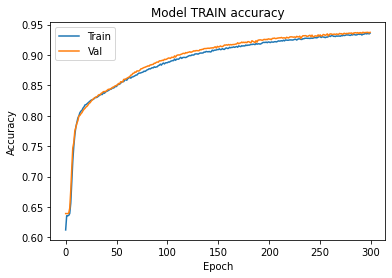

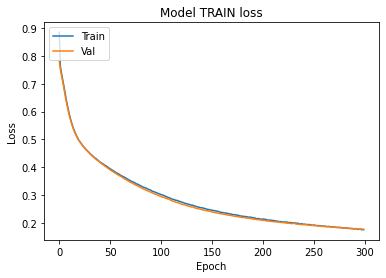

In [ ]:
# One-hot encoding the test labels
test_labels=np.vectorize(dict.get)(testLabels)
test_labels_enc = to_categorical(test_labels)

score = model.evaluate(subImagesTestset, test_labels_enc, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

# Plot it - we can see "convergence"
plt.figure()
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])  #if validation_split>0
plt.title('Model TRAIN accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')

# Plot training & validation loss values
plt.figure()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss']) #if validation_split>0
plt.title('Model TRAIN loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

In [ ]:
score2 = model.evaluate(subImagesTrainset, trainLabelsEncoded, verbose=0)
print("Train accuracy: ",score2[1])

Train accuracy:  0.9379705786705017


## Visualization of predictions on test-set

The Following Code cell is useful for visulizing the predictions made on the test set.

In [ ]:
# Google colab patch for imshow, if using any other IDE/Environment this patch not needed
from google.colab.patches import cv2_imshow 

# The following variable select the sub-image for which we want to display the
# full image along with all the other sub-images in that particular full image.   
sub_image_index=900

image = Image.open('/content/gdrive/MyDrive/test_images/'+dataframeTest[sub_image_index][1])
image = np.asarray(image) #/ 255.0
testImages.append( image )

# First reading the annotations file of the full image and then extracting the 
# bounding boxes of each individual sub-image 
firstcount=0
lastcount=0
counter=0
for i in range(0,testsetLength):
 if((dataframeTest[i][1]==dataframeTest[sub_image_index][1])and(counter==0)):
    firstcount=i
    counter=1
    lastcount=i+1
 if ((dataframeTest[i][1] == dataframeTest[sub_image_index][1]) and (counter == 1)):
     lastcount=i

# Next, making predictions on all the sub-images in the full image 
# using the trained model
y_predVisulize = model.predict_proba(subImagesTestset[firstcount:lastcount+1])
temp=[]
y_predVisulizeLabels=[]
for i in range(0,y_predVisulize.shape[0]):
 tempMax = np.argmax(y_predVisulize[i])
 y_predVisulizeLabels.append(tempMax)
 #print(y_predVisulize[i][tempMax])
 temp.append(y_predVisulize[i][tempMax])
sub_img_count=0

# Using the dictionary to get back the categorical-labels
dict2 = {0:'airplane',1:'vehicle',2:'ship'}
test_pred_labels = np.vectorize(dict2.get)(y_predVisulizeLabels)
import cv2

# The full image read was appended at the end of testImages for visualization
firstimg = testImages[-1]

# Locating the sub-images on the full image and printing 
# the predictions on it using opencv2 
for i in range(0,xml_dataframeTestset.shape[0]):
 
 if xml_dataframeTestset[i,0]==dataframeTest[sub_image_index][1]: 
  sub_img_count=sub_img_count+1
  single_object = xml_dataframeTestset[i]
  
  bb0_pred = single_object[4:8]
  # To draw a rectangle around all the sub-images inside the full image
  cv2.rectangle(firstimg, (bb0_pred[0], bb0_pred[1]), (bb0_pred[2], bb0_pred[3]), (255, 255, 255), 1)  
  font = cv2.FONT_HERSHEY_SIMPLEX
  # Printing the predictions on the image using string operations
  T=temp[sub_img_count-2]
  T=str(T)+": "+test_pred_labels[sub_img_count-2]
  cv2.putText(firstimg, T ,(bb0_pred[0],bb0_pred[1]), font, 0.75,(255,255,255),1,cv2.LINE_AA)
cv2_imshow(firstimg)
# Deleting that full-image from testImages as it is already there 
# and would be redundant to keep in the test set after Visulization is complete
testImages = np.delete(testImages, -1) 

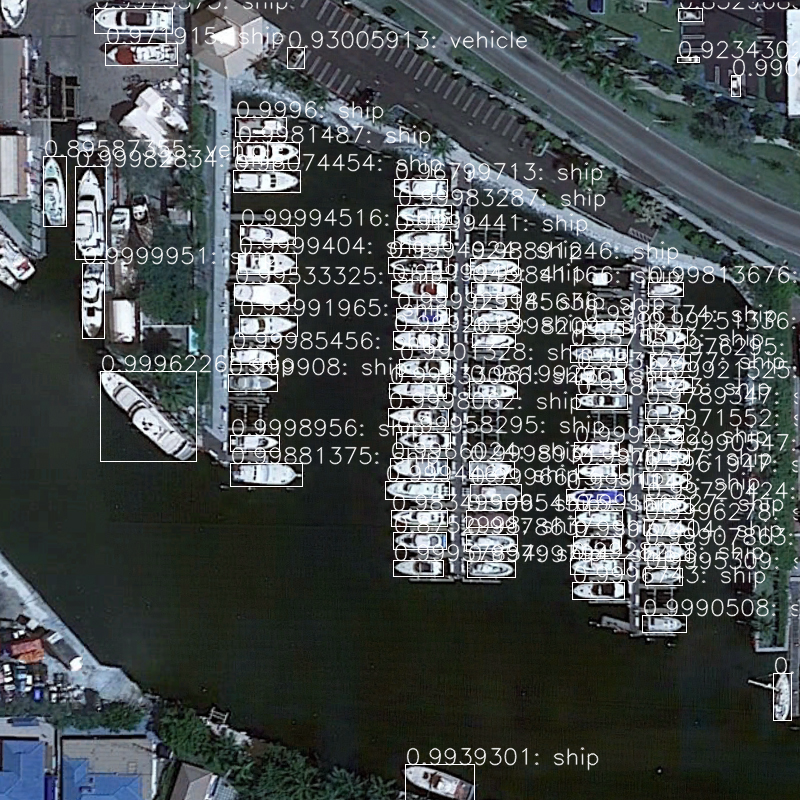

In [ ]:
cv2_imshow(firstimg)